# Test: analysis via zoom into protostars and cutouts of the HC3N cube

The idea is to see if there are regions with possible streamers

In [1]:
import numpy as np
import os
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
from astropy.nddata.utils import Cutout2D
from spectral_cube import SpectralCube
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
%matplotlib widget

sourcecat = '../../data/my_catalog_vel.csv'
cubefile = '../../data/NGC1333_HC3N_L24-merged_small_K.fits'
mlex1file = '../../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_filtered_QA.fits'
mlex2file = '../../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x2_filtered_QA.fits'
mlex3file = '../../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x3_filtered_QA.fits'

subcubes_basename = 'SK15_HC3N_{}'

radiuscut = 25 *u.arcsec # thats 7450 au radius

In [2]:
cube = SpectralCube.read(cubefile)
wcsskycube = WCS(cube.header).celestial

mlex1, mlex1head = fits.getdata(mlex1file, header=True)
mlex2, mlex2head = fits.getdata(mlex2file, header=True)
mlex3, mlex3head = fits.getdata(mlex3file, header=True)

catalog_protostars = pd.read_csv(sourcecat)
# sk15 is the 15 source, not intentionally
racent, deccent = catalog_protostars.loc[15, ['RAJ2000', 'DEJ2000']].values

vlsr = catalog_protostars.loc[15, 'vlsr']

In [3]:
# here we cut the images
centerx, centery = wcsskycube.all_world2pix([racent], [deccent], 0)
centerx, centery = int(centerx[0]), int(centery[0])

radiuspix = int(np.round(radiuscut.to(u.deg).value / np.abs(cube.header['CDELT2']), 0))

In [4]:
centery-radiuspix

370

In [5]:
if not os.path.exists(subcubes_basename.format('cube.fits')):
    subcube = cube[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    subcube.write(subcubes_basename.format('cube.fits'))
    

else:
    subcube = SpectralCube.read(subcubes_basename.format('cube.fits'))
headersmall = subcube.header   

In [6]:

if not os.path.exists(subcubes_basename.format('mlex1.fits')):
    submlex1 = mlex1[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    headersubmlex1 = mlex1head.copy()
    headersubmlex1['NAXIS1'] = 2*radiuspix + 1
    headersubmlex1['NAXIS2'] = 2*radiuspix + 1
    fits.writeto(subcubes_basename.format('mlex1.fits'), submlex1, headersubmlex1)
else:
    submlex1, headersubmlex1 = fits.getdata(subcubes_basename.format('mlex1.fits'), header=True)

if not os.path.exists(subcubes_basename.format('mlex2.fits')):
    submlex2 = mlex2[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    headersubmlex2 = mlex2head.copy()
    headersubmlex2['NAXIS1'] = 2*radiuspix + 1
    headersubmlex2['NAXIS2'] = 2*radiuspix + 1
    fits.writeto(subcubes_basename.format('mlex2.fits'), submlex2, headersubmlex2)
else:
    submlex2, headersubmlex2 = fits.getdata(subcubes_basename.format('mlex2.fits'), header=True) 

if not os.path.exists(subcubes_basename.format('mlex3.fits')):
    submlex3 = mlex3[:, centery-radiuspix:centery+radiuspix, centerx-radiuspix:centerx+radiuspix]
    headersubmlex3 = mlex3head.copy()
    headersubmlex3['NAXIS1'] = 2*radiuspix + 1
    headersubmlex3['NAXIS2'] = 2*radiuspix + 1
    fits.writeto(subcubes_basename.format('mlex3.fits'), submlex3, headersubmlex3)
else:
    submlex3, headersubmlex3 = fits.getdata(subcubes_basename.format('mlex3.fits'), header=True) 



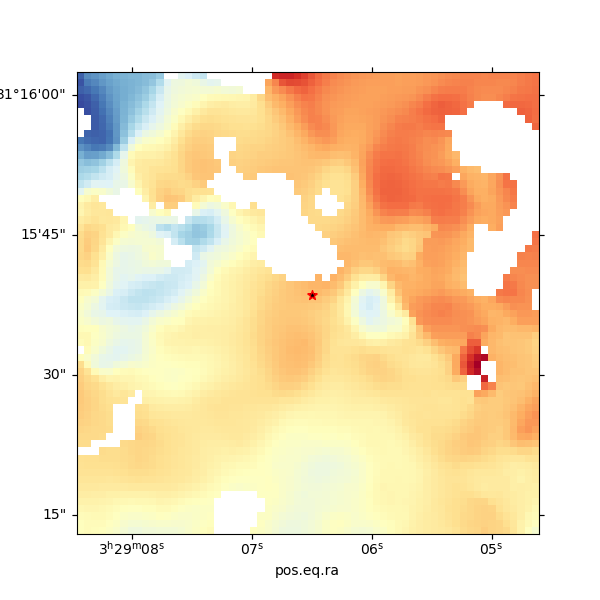

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': WCS(headersmall).celestial})

ax.imshow(submlex1[1] - vlsr, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax.scatter(racent, deccent, transform=ax.get_transform('world'), marker='*', s=50, fc='k', ec='r')

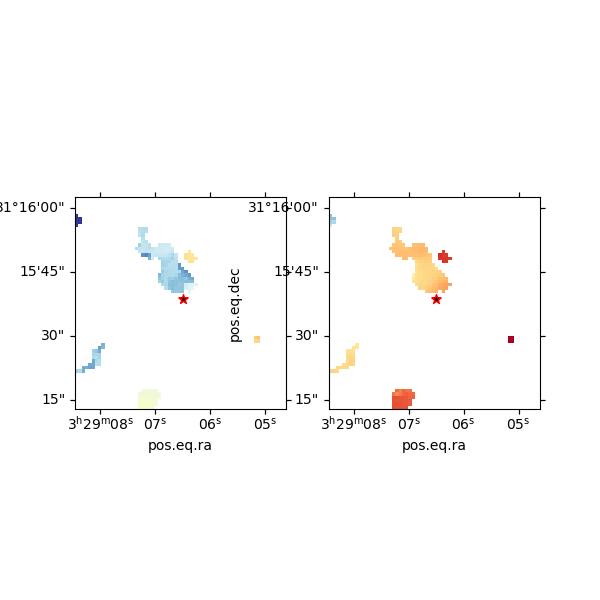

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6,6), subplot_kw={'projection': WCS(headersmall).celestial})

ax1.imshow(submlex2[1] - vlsr, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax1.scatter(racent, deccent, transform=ax1.get_transform('world'), marker='*', s=50, fc='k', ec='r')
ax2.imshow(submlex2[4] - vlsr, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax2.scatter(racent, deccent, transform=ax2.get_transform('world'), marker='*', s=50, fc='k', ec='r')

It seems that the more blueshifted component is not associated with the larger cloud

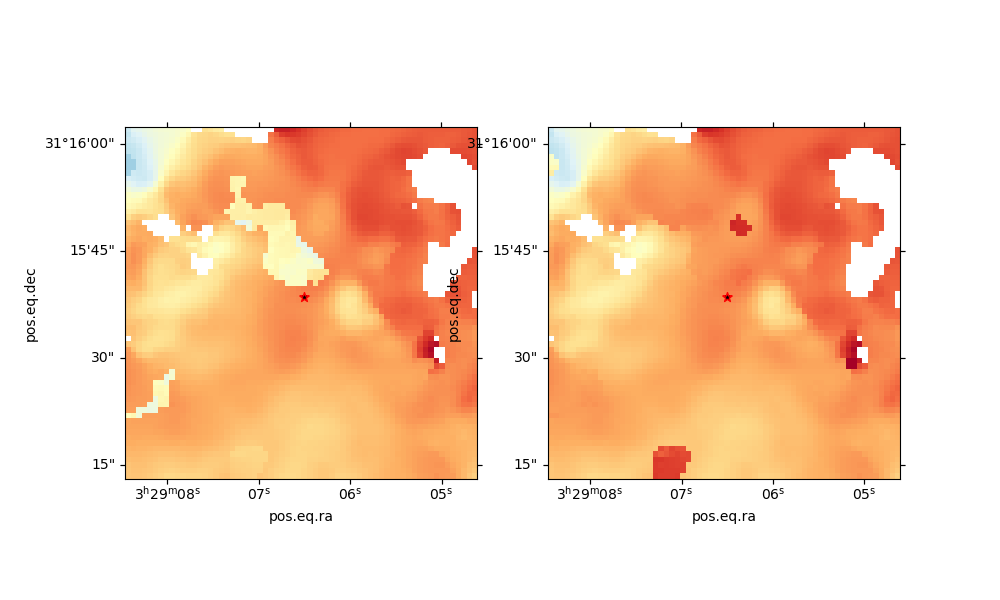

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2 ,figsize=(10,6), subplot_kw={'projection': WCS(headersmall).celestial})

ax1.imshow(submlex2[1], cmap='RdYlBu_r', vmin=6, vmax=9)
ax1.imshow(submlex1[1], cmap='RdYlBu_r', vmin=6, vmax=9)
ax1.scatter(racent, deccent, transform=ax1.get_transform('world'), marker='*', s=50, fc='k', ec='r')
ax2.imshow(submlex2[4], cmap='RdYlBu_r', vmin=6, vmax=9)
ax2.imshow(submlex1[1], cmap='RdYlBu_r', vmin=6, vmax=9)
ax2.scatter(racent, deccent, transform=ax2.get_transform('world'), marker='*', s=50, fc='k', ec='r')

We need to see how is its tendency with respect to the protostar's vlsr


In [19]:
from scipy.stats import gaussian_kde

def distance_au(x, y, xcent, ycent, header, distance_source=298):
    dist = np.hypot(np.abs(x-xcent), np.abs(y-ycent))
    return (dist*header['CDELT2'] * u.deg).to(u.arcsec).value * distance_source

In [20]:
velsample = mlex1[1, centery:, centerx-int(radiuspix/2):centerx+int(radiuspix/2)]
xlen, ylen = np.shape(velsample)
XX, YY = np.meshgrid()

In [21]:
xlen

123

In [ ]:



# here we build the space for the KDE to be plotted
xmin = 0
xmax = 10000
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

gd_vlos = np.isfinite(velarray_mol1*distarray_mol1)